In [2]:
from numpy.random import normal
from math import sqrt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import Dataset
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import torchvision
import warnings
torch.set_default_tensor_type(torch.FloatTensor)
import copy
warnings.filterwarnings("ignore")

In [3]:
def make_txt_file(path):
    
    # Classes: train, eval, test
    img_path=os.path.join(path,'TrainVal_images')
    label_path=os.path.join(path,'TrainVal_parsing_annotations')
    train_data=open('train.txt', 'w')
    eval_data=open('eval.txt','w')
    test_data=open('test.txt','w')
    train_data.truncate()
    eval_data.truncate()
    test_data.truncate()
    train_id=open(os.path.join(path,'train_id.txt'))
    val_id=open(os.path.join(path,'val_id.txt'))
    
    train_data_path=os.path.join(img_path,'train_images')
    val_data_path=os.path.join(img_path,'val_images')
    train_label_path=os.path.join(label_path,'train_segmentations')
    val_label_path=os.path.join(label_path,'val_segmentations')
    
    lines=train_id.readlines()
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(train_data_path,line+'.jpg')+'*'+os.path.join(train_label_path,line+'.png')+'\n'
        train_data.write(name)
        count+=1
        if count>=600:
            break
    train_data.close()
    train_id.close()
    
    lines=val_id.readlines()
    s=0
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(val_data_path,line+'.jpg')+'*'+os.path.join(val_label_path,line+'.png')+'\n'
        if s%2==0:
            eval_data.write(name)
        else:
            test_data.write(name)
        s+=1
        
        count+=1
        if count>=100:
            break
            
    val_id.close() 
    eval_data.close()
    test_data.close()
                
    


In [4]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None,update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/pil-data/LIP'
        read_path=''
 
        if update_dataset:
            make_txt_file(dataset_path) 
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(os.path.join(read_path , self.dataset_type + '.txt'))
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('*')[0]).convert('RGB')       
        label = Image.open(item.split('*')[1]).convert('L')
        
        if self.transform is not None:
            img,label = self.transform(img,label)
           
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [5]:
def train_transform(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))    

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label)
    label=(label>=1).astype(int) 
    label=transforms.functional.to_tensor(label).float()
    return data,label

def test_transfrom(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))
    data=transforms.functional.to_tensor(data).float()

    label=np.array(label)
    label=(label>=1).astype(int)  
    label=transforms.functional.to_tensor(label).float()
    return data,label
    

In [6]:
train_data=MyDataSet('train',transform=train_transform,update_dataset=True)
eval_data=MyDataSet('eval',test_transfrom)

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, input):        
        return self.conv(input)

In [8]:
class UNet(nn.Module):
    def __init__(self,colordim =1):
        super(UNet, self).__init__()
        self.conv1=DoubleConv(3,64)
        self.conv2=DoubleConv(64,128)
        self.conv3=DoubleConv(128,256)
        self.conv4=DoubleConv(256,512)
        
        self.conv5=DoubleConv(512,1024)
        self.upconv5=nn.Conv2d(1024, 512, 1)
        
        self.conv6=DoubleConv(1024,512)
        self.upconv6=nn.Conv2d(512, 256, 1)
        self.conv7=DoubleConv(512,256)
        self.upconv7=nn.Conv2d(256,128, 1)
        self.conv8=DoubleConv(256,128)
        self.upconv8=nn.Conv2d(128,64, 1)
        self.conv9=DoubleConv(128,64)
        
        self.maxpool=nn.MaxPool2d(2, stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        self.output=nn.Sequential(
            nn.Conv2d(64, colordim, 1),
            nn.Sigmoid()
        )
        self._initialize_weights()
    
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(self.maxpool(x1))
        x3=self.conv3(self.maxpool(x2))
        x4=self.conv4(self.maxpool(x3))
        upx=self.conv5(self.maxpool(x4))
        
        upx=self.upconv5(self.upsample(upx))     

        upx=self.conv6(torch.cat((x4, upx), 1))
        upx=self.upconv6(self.upsample(upx))   

        upx=self.conv7(torch.cat((x3, upx), 1))
        upx=self.upconv7(self.upsample(upx))  

        upx=self.conv8(torch.cat((x2, upx), 1))
        upx=self.upconv8(self.upsample(upx)) 

        upx=self.conv9(torch.cat((x1, upx), 1))
        upx=self.output(upx)
        
        return upx
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()        
        
        

In [9]:
unet = UNet().cuda()

In [10]:
EPOCH = 70
BATCH_SIZE=32
LR=0.001

optimizer=torch.optim.Adam(unet.parameters(),lr=LR)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
    verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)

loss_func=nn.MSELoss()


train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=True, num_workers=2)

In [11]:
train_losses=[]
eval_losses=[]



for epoch in range(EPOCH):
    print('Epoch: %4s'%epoch)
    

    batch_loss=0
    unet.train()  
    
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output=unet(b_x)   
        loss=loss_func(output,b_y)
        batch_loss+=loss.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        torch.cuda.empty_cache() 

    train_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
    train_losses.append(train_loss)
    scheduler.step(train_loss) 
    
    print('| train loss: ',train_loss)
    
    
    
    with torch.no_grad():
        unet.eval()         

        batch_loss=0
        for step,(x,y) in enumerate(eval_loader):
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()    
            output=unet(b_x)  
            batch_loss+=loss_func(output,b_y).data            
            torch.cuda.empty_cache()            

        eval_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
        eval_losses.append(eval_loss)

    
    print('| eval loss: ',eval_loss) 

Epoch:    0
| train loss:  tensor(0.2974, device='cuda:0')
| eval loss:  tensor(0.1607, device='cuda:0')
Epoch:    1
| train loss:  tensor(0.2241, device='cuda:0')
| eval loss:  tensor(0.1416, device='cuda:0')
Epoch:    2
| train loss:  tensor(0.2094, device='cuda:0')
| eval loss:  tensor(0.1294, device='cuda:0')
Epoch:    3
| train loss:  tensor(0.2068, device='cuda:0')
| eval loss:  tensor(0.1172, device='cuda:0')
Epoch:    4
| train loss:  tensor(0.2015, device='cuda:0')
| eval loss:  tensor(0.1195, device='cuda:0')
Epoch:    5
| train loss:  tensor(0.1980, device='cuda:0')
| eval loss:  tensor(0.1183, device='cuda:0')
Epoch:    6
| train loss:  tensor(0.2001, device='cuda:0')
| eval loss:  tensor(0.1213, device='cuda:0')
Epoch:    7
| train loss:  tensor(0.1969, device='cuda:0')
| eval loss:  tensor(0.1154, device='cuda:0')
Epoch:    8
| train loss:  tensor(0.1906, device='cuda:0')
| eval loss:  tensor(0.1074, device='cuda:0')
Epoch:    9
| train loss:  tensor(0.1920, device='cuda:

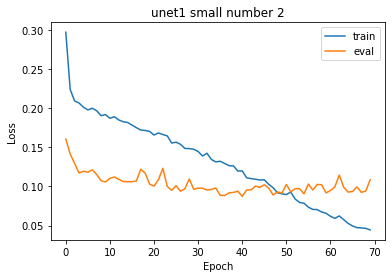

In [13]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('unet1 small number 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

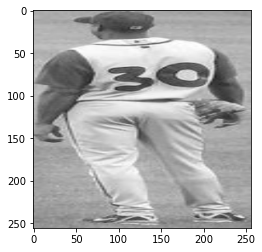

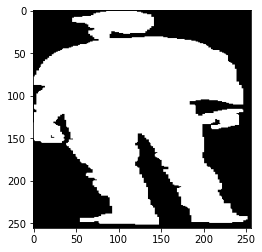

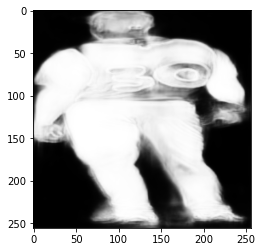

In [14]:
img,label=train_data.__getitem__(2)
plt.imshow(np.transpose(img.numpy(),(1,2,0)))
plt.show()

plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
plt.show()

img=torch.unsqueeze(img,dim=0)
b_x=Variable(img).cuda()
output=unet(b_x).to(torch.float64)
plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))
plt.show()

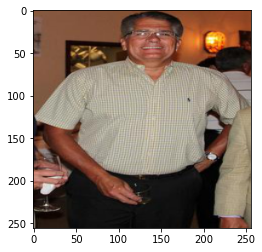

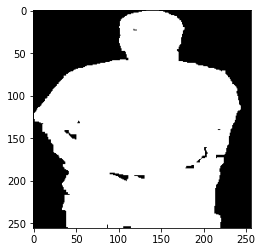

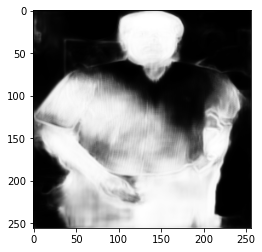

In [15]:
img,label=eval_data.__getitem__(10)
plt.imshow(np.transpose(img.numpy(),(1,2,0)))
plt.show()

plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
plt.show()

img=torch.unsqueeze(img,dim=0)
b_x=Variable(img).cuda()
output=unet(b_x).to(torch.float64)
plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))
plt.show()

In [16]:
test_data=MyDataSet('test',test_transfrom)

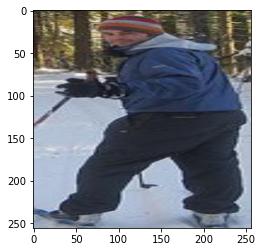

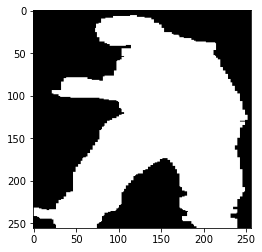

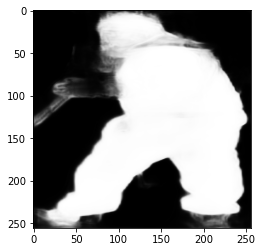

In [17]:
img,label=test_data.__getitem__(10)
plt.imshow(np.transpose(img.numpy(),(1,2,0)))
plt.show()

plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
plt.show()

img=torch.unsqueeze(img,dim=0)
b_x=Variable(img).cuda()
output=unet(b_x).to(torch.float64)
plt.imshow(output.cpu().detach().numpy()[0][0],cmap = plt.get_cmap('gray'))
plt.show()